In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
import scikitplot as skplt

from catboost import Pool, CatBoostClassifier

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Hi everyone, I am new to Kaggle. Recently I started pursuing ML , data science. I was interested in utilizing catboost. I noticed few using GridSearch for model Selection, but I do not see much difference as Catboost in itself gives an accuracy if the parameters are refined to consider the best model. Please share your feedback. 
Note: I have referred multiple author's code to come up with my model. Please excuse me for not giving credits. 

In [2]:
#train and test data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Identify Null values and fill it with NA or negative value so that Catbooster can distinguish it

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#catboost will identify NA
train.fillna(-1,inplace=True)
test.fillna(-1,inplace=True)

In [6]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

**Explore**

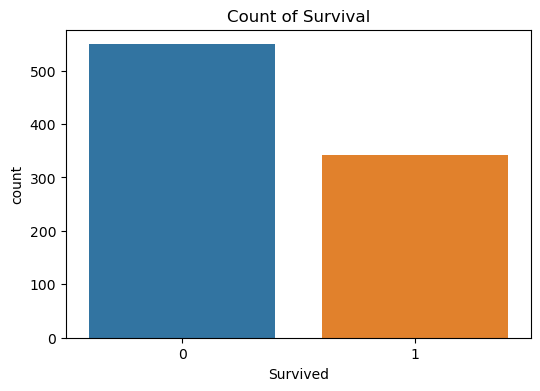

In [7]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Count of Survival")
plt.show()


In [8]:
category=['Pclass','Sex','Embarked']
numerical=['Age','SibSp','Parch','Fare']

Peasrson Correlation for Numerical Variables

In [9]:
corr=train[numerical]  
correlation= corr.corr(method='pearson')
print(correlation)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.182282 -0.045272  0.135707
SibSp -0.182282  1.000000  0.414838  0.159651
Parch -0.045272  0.414838  1.000000  0.216225
Fare   0.135707  0.159651  0.216225  1.000000


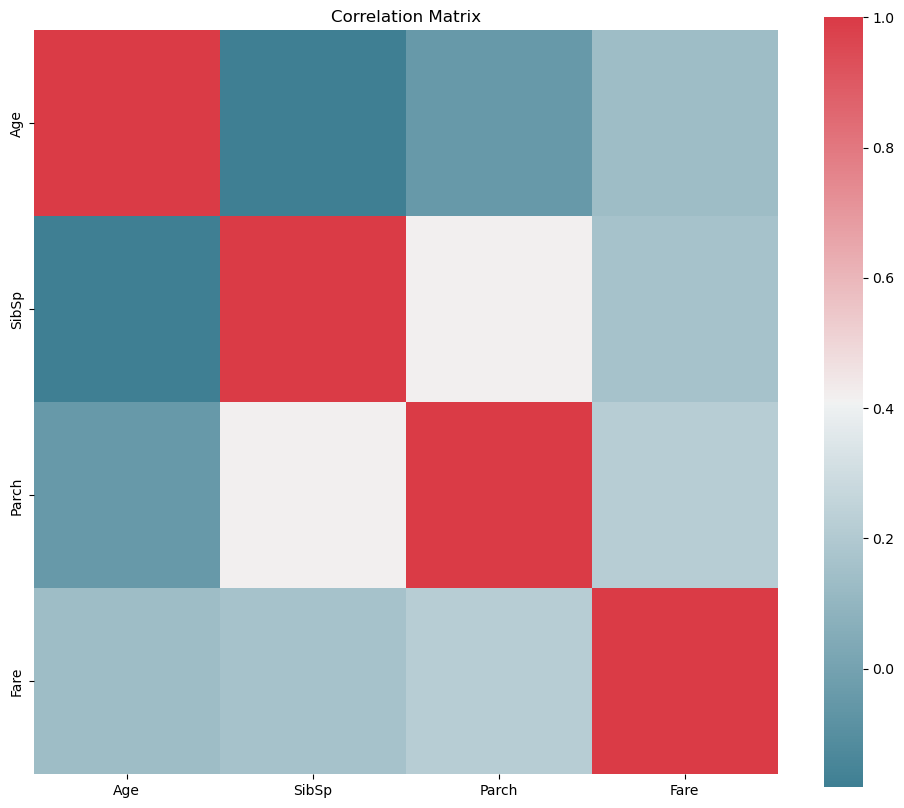

In [10]:
fig, ax =plt.subplots(figsize=(12, 10))
plt.title("Correlation Matrix")
sns.heatmap(correlation, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Chi Square for Categorical variables

In [11]:
chisqG=chi2_contingency(pd.crosstab(train['Survived'], train['Sex']))
print("P value: ",chisqG[1])

P value:  1.1973570627755645e-58


In [12]:
chisqE=chi2_contingency(pd.crosstab(train['Survived'], train['Embarked']))
print("P value: ",chisqE[1])

P value:  1.61871880094504e-06


In [13]:
chisqC=chi2_contingency(pd.crosstab(train['Survived'], train['Pclass']))
print("P value :",chisqC[1])

P value : 4.549251711298793e-23


Rejecting the null hypothesis as the values are low.

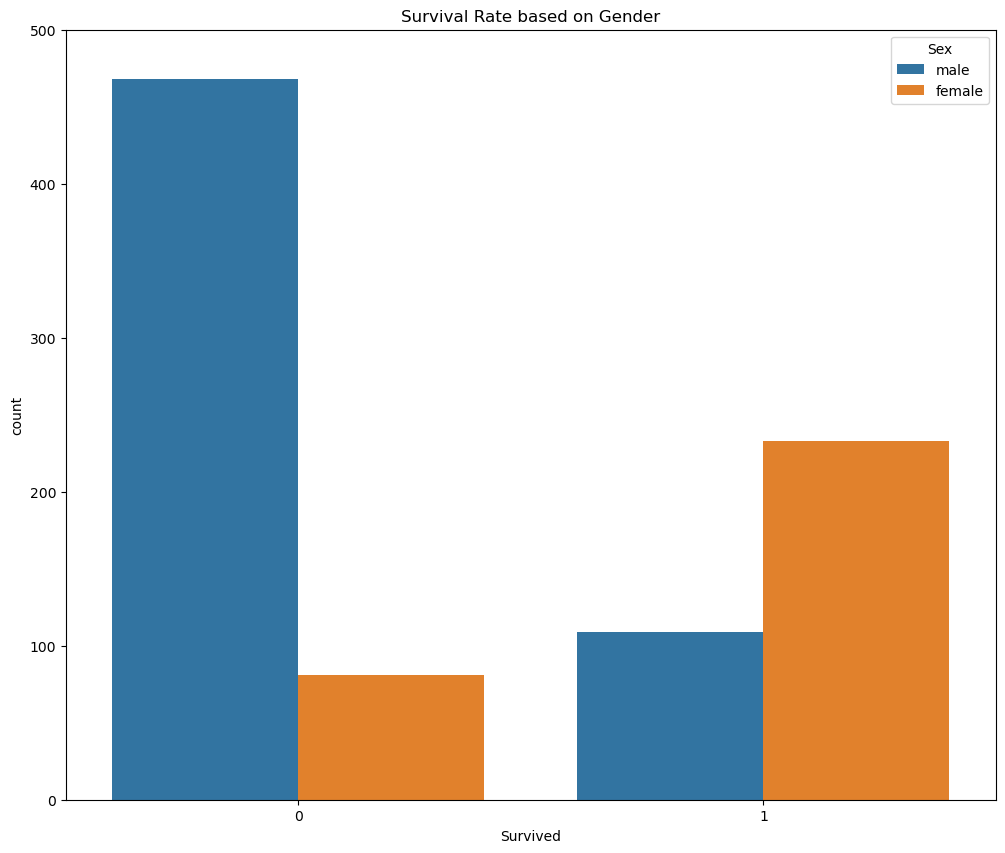

In [14]:
fig, ax=plt.subplots(figsize=(12,10))
sns.countplot(x='Survived', data=train, hue='Sex')
ax.set_ylim(0,500)
plt.title("Survival Rate based on Gender")
plt.show()

Proving the general assumption that Female survival rate is high

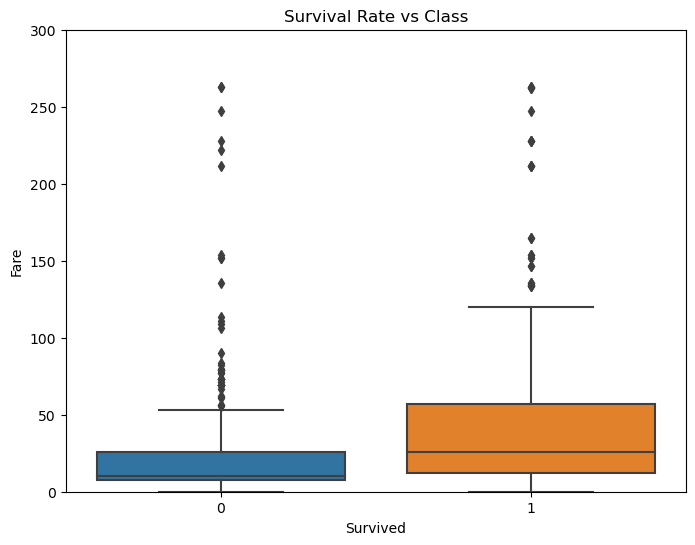

In [15]:
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Fare', data=train)
ax.set_ylim(0,300)
plt.title("Survival Rate vs Class")
plt.show()

In [16]:
#Prepare train and test 
x = train.drop('Survived',axis=1)
y = train.Survived

In [17]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=.80,random_state=42)
cat_features = np.where(x.dtypes != float)[0]

train_pool = Pool(xtrain, ytrain, cat_features=cat_features)

model = CatBoostClassifier(logging_level='Silent', eval_metric='Accuracy',random_seed=42)


In [18]:
fit_model=model.fit(train_pool,eval_set=(xtest,ytest))
predict=fit_model.predict(xtest)

# Accuracy (proportion of correct predictions), Precision (true positives over total predicted positives), Recall (true positives over total actual positives), F1 score (harmonic mean of precision and recall)

In [19]:
print('Catboost accuracy is :{:.5f}'.format(accuracy_score(ytest,predict)))
print('Classification Report', classification_report(ytest,predict))

Catboost accuracy is :0.84358
Classification Report               precision    recall  f1-score   support

           0       0.83      0.91      0.87       105
           1       0.86      0.74      0.80        74

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



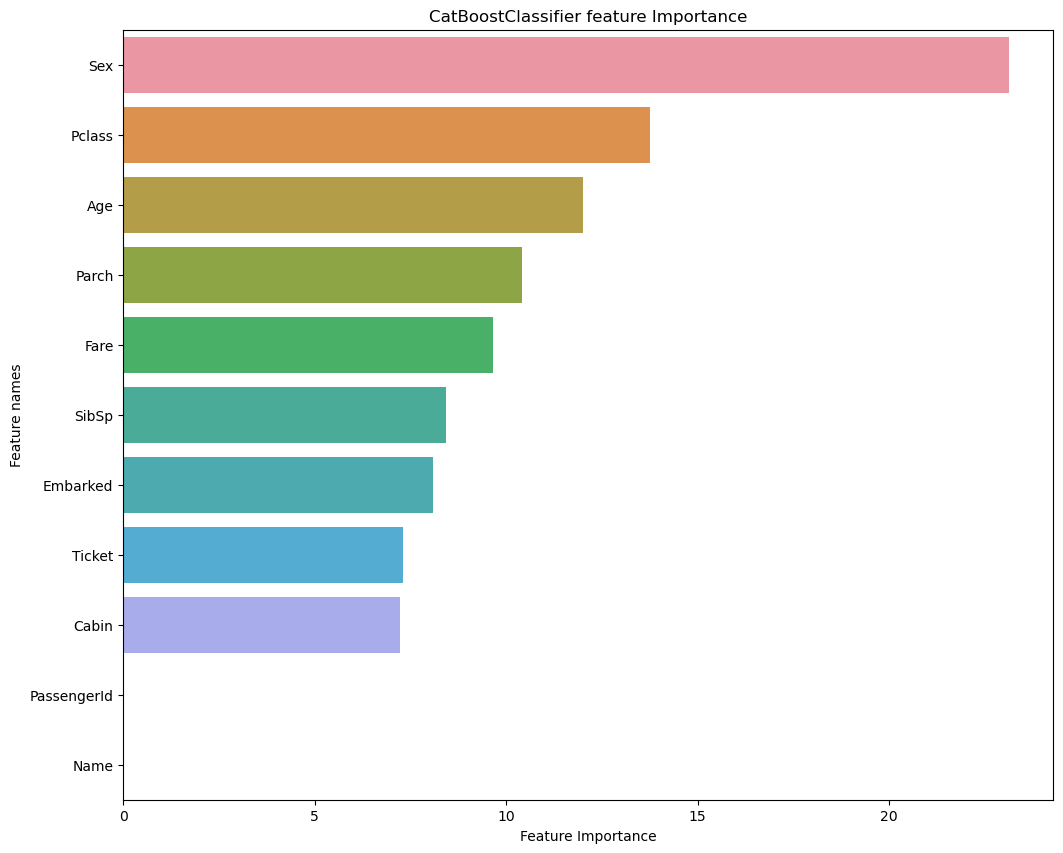

In [20]:
plt.figure(figsize=(12,10))
fs = pd.Series(model.get_feature_importance(), index=x.columns).sort_values(ascending=False)
sns.barplot(x=fs.values, y=fs.index)
plt.title('CatBoostClassifier feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature names')
plt.show()

# **ROC Curve: A probability curve that plots the TPR(True Positive Rate) against the FPR(False Positive Rate) at various threshold values and separates the ‘signal’ from the ‘noise’.**

<Figure size 1200x1000 with 0 Axes>

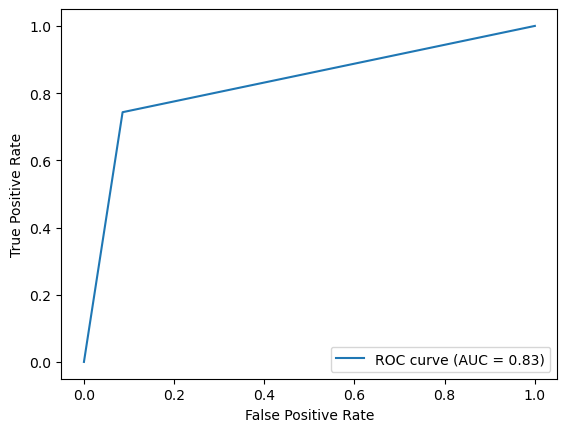

In [21]:
plt.figure(figsize=(12,10))
fpr, tpr, thresholds = roc_curve(ytest, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

# Try applying Grid Search to see if it improves accuracy

In [22]:
cb= CatBoostClassifier(cat_features=cat_features)
parameters = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
#           'eval_metric': ['Accuracy'],
#           'use_best_model': ['True'],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
model_catboost = GridSearchCV(
    cb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

In [23]:
model_catboost.fit(xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7cd3a44f57e0>,
             param_grid={'depth': [4, 5, 6], 'iterations': [500],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'leaf_estimation_iterations': [10],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy'],
                         'random_seed': [42]},
             scoring='accuracy')

In [24]:
best_param = model_catboost.best_params_
best_param

{'depth': 4,
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

In [25]:
best_score = model_catboost.best_score_
best_score

0.8230867723825469

In [26]:
bpmodel = CatBoostClassifier(iterations=500,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent',
                           random_seed=42
                          )
bestcb = bpmodel.fit(train_pool, eval_set=(xtest,ytest))


In [27]:
bppredict=bestcb.predict(xtest)

In [28]:
print('Catboost accuracy with gridsearch is :{:.5f}'.format(accuracy_score(ytest,bppredict)))


Catboost accuracy with gridsearch is :0.83240


DIFFERENCE BETWEEN DEFAULT CATBOOST AND GRIDSERCH BEST PARAM CATBOOST

<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

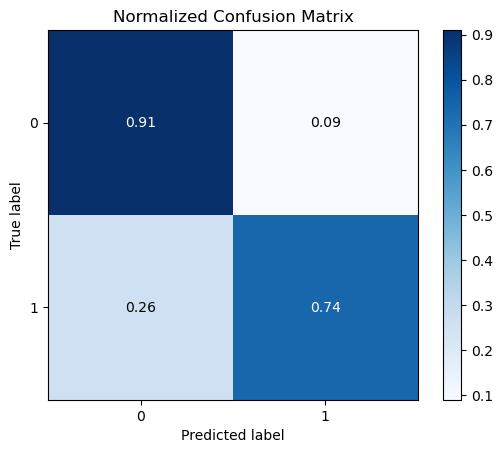

In [29]:
skplt.metrics.plot_confusion_matrix(ytest, predict, normalize=True)


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

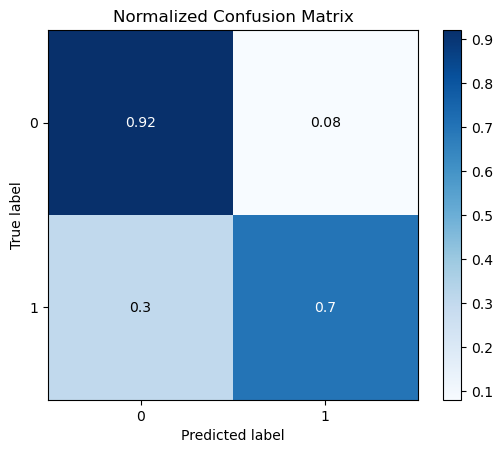

In [30]:
skplt.metrics.plot_confusion_matrix(ytest, bppredict, normalize=True)


In [31]:
pred = fit_model.predict(test)
pred = pred.astype(np.int)
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred})
#make the file to yourself's directory
submission.to_csv('catboost.csv',index=False)

/tmp/ipykernel_20/1403781632.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = pred.astype(np.int)
